# HMMs for Social and Communication App Usage Data Modelling

Different HMMs are trained with all patient sequences, regardless of the number of observations and the presence
of the observables.

## Load the Data

In [4]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# --- define the columns corresponding to different variables of interest
data_columns = ["nCommunication", "nSocial"]

# --- load preprocessed data
PATH_TO_DATA = None
df_train = pd.read_csv(PATH_TO_DATA + "temp_data.csv")
df_train["date"] = pd.to_datetime(df_train["date"], format = "%Y-%m-%d")

# --- sort by patient id and date (just for convenience)
df_train.sort_values(by=["user", "date"], ascending=[True, True], inplace=True)

# --- standardize the temporal data
df_train[data_columns] = StandardScaler().fit_transform(df_train[data_columns])

print("There are {} patient sequences".format(df_train.user.nunique()))

There are 95 patient sequences


### Transform Dataframe to list of patient sequences

In [5]:
import numpy as np
from code.utils import df_to_list

# --- transform the columns of interest into list of observations
all_seq = df_to_list(df_train, data_columns, by_year = True)

## HMM Training

We train HMMs using all patient sequences. The states have Gaussian emissions with diagonal covariance matrices.

In [6]:
import multiprocessing as mp
import pyhhmm.utils as hu
from pyhhmm.gaussian import GaussianHMM

# --- define folder path where to save results
PATH_TO_RESULTS = None
folder_path = PATH_TO_RESULTS + "models/hmm/")

# --- list of states to consider
n_states = [2, 3, 5, 7, 9, 11, 13, 17, 19]

for ns in n_states:
    print("Training HMM with {} states.".format(ns))
    print("-----------------------------")

    # create the model
    hmm = GaussianHMM(
        n_states=ns,
        n_emissions=len(data_columns),
        learn_rate=0.,
        params="stmc",
        init_params="stmc",
        init_type="random",
        covariance_type="diagonal",
        verbose=True,
    )

    hmm, _ = hmm.train(
        all_seq, n_init=1, n_iter=250, thres=0.001, conv_iter=5,
        plot_log_likelihood=False, n_processes=mp.cpu_count(), print_every=10
    )

    # save the model
    hu.save_model(hmm, folder_path + "{}_state_hmm.p".format(ns))
    
    print()

Training HMM with 2 states.
-----------------------------
Initialisation 1
iter: 0, logL = -19837.227, delta = nan
iter: 10, logL = -18053.727, delta = 220.559
iter: 20, logL = -16427.757, delta = 68.703
Converged -> iter: 28, logL = -16265.132

Training HMM with 3 states.
-----------------------------
Initialisation 1
iter: 0, logL = -19753.865, delta = nan
iter: 10, logL = -15929.008, delta = 200.260
iter: 20, logL = -14661.840, delta = 229.614
iter: 30, logL = -8665.126, delta = 698.676
iter: 40, logL = -6249.489, delta = 11.020
Converged -> iter: 45, logL = -6237.696

Training HMM with 5 states.
-----------------------------
Initialisation 1
iter: 0, logL = -19804.980, delta = nan
iter: 10, logL = -15851.642, delta = 313.451
iter: 20, logL = -11857.434, delta = 721.896
iter: 30, logL = -5844.933, delta = 37.639
Converged -> iter: 39, logL = -5780.219

Training HMM with 7 states.
-----------------------------
Initialisation 1
iter: 0, logL = -19761.207, delta = nan
iter: 10, logL = 

## Model order selection

We apply stepwise model selection, which typically uses as measure of performance an information criterion. An
information criterion balances the fitness of a model with the number of predictors employed. Hence, it determines
objectively the best model as the one that minimizes the considered information criterion. Two common criteria are
the Bayesian Information Criterion (BIC) and the Akaike Information Criterion (AIC). Both are based on balancing the
model fitness and its complexity:
\begin{align} \text{BIC}(\text{model}) = \underbrace{-2\ell(\text{model})}_{\text{Model fitness}} +
    \underbrace{\text{npar(model)}\times\log(n)}_{\text{Complexity}}, \tag{1} \end{align}
where $\ell(\text{model})$ is the log-likelihood of the model (how well the model fits the data) and  $\text{npar(model)}$
is the number of parameters considered in the model (how complex the model is).
The AIC replaces the $\log(n)$ factor by a 2 so, compared with the BIC, it penalizes less the more complex models.

The best model will be the one that offers the best trade-off between model complexity and fitness of the model.

2 states.
-----------
logL = -16265.242, AIC = 32558.485, BIC = 32655.357 

3 states.
-----------
logL = -6237.448, AIC = 12522.896, BIC = 12688.963 

5 states.
-----------
logL = -5778.960, AIC = 11657.921, BIC = 12003.893 

7 states.
-----------
logL = -5731.265, AIC = 11630.530, BIC = 12211.764 

9 states.
-----------
logL = -5997.252, AIC = 12246.504, BIC = 13118.355 

11 states.
-----------
logL = -6362.427, AIC = 13076.854, BIC = 14294.677 

13 states.
-----------
logL = -6711.431, AIC = 13890.862, BIC = 15510.014 

17 states.
-----------
logL = -7186.170, AIC = 15120.339, BIC = 17708.215 

19 states.
-----------
logL = -7246.869, AIC = 15405.738, BIC = 18561.008 



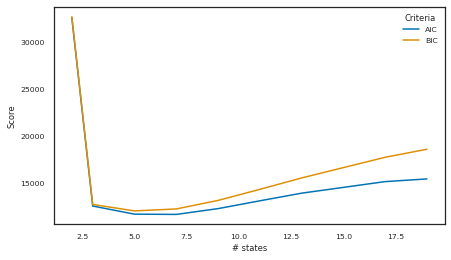

In [7]:
# seq = [all_seq[i] for i in np.random.choice(np.arange(len(all_seq)), 50)]
crit_stats = []
for ns in n_states:
    print("{} states.".format(ns))
    print("-----------")

    hmm = hu.load_model(folder_path + "{}_state_hmm.p".format(ns))
    dof = hu.get_n_fit_scalars(hmm)

    logL = hmm.score(all_seq)

    aic = hu.aic_hmm(logL, dof)
    bic = hu.bic_hmm(logL, dof, sum([len(obs) for obs in all_seq]))

    print("logL = {:.3f}, AIC = {:.3f}, BIC = {:.3f} \n".format(logL, aic, bic))

    crit_stats.append([ns, "AIC", aic])
    crit_stats.append([ns, "BIC", bic])

hu.plot_model_selection(pd.DataFrame(data=crit_stats,columns=["# states", "Criteria", "Score"]))


Looks like the 3- or 5-state model should be considered. To try to interpret the states, we can look at the model
parameters in more details.

## HMM Analysis

### 3-state HMM

#### Model parameters

In [5]:
# --- load the trained model
hmm = hu.load_model(folder_path + "3_state_hmm.p")

# --- print model parameters
hu.pretty_print_hmm(hmm, hmm_type="Gaussian", emissions=data_columns)

Priors
+------------+------------+------------+
|  State_0   |  State_1   |  State_2   |
+------------+------------+------------+
| P(0)=0.301 | P(1)=0.449 | P(2)=0.250 |
+------------+------------+------------+
Transitions
+---------+--------------+--------------+--------------+
|    _    |   State_0    |   State_1    |   State_2    |
+---------+--------------+--------------+--------------+
| State_0 | P(0|0)=0.665 | P(1|0)=0.102 | P(2|0)=0.233 |
| State_1 | P(0|1)=0.078 | P(1|1)=0.877 | P(2|1)=0.045 |
| State_2 | P(0|2)=0.213 | P(1|2)=0.065 | P(2|2)=0.723 |
+---------+--------------+--------------+--------------+
Means
+---------+----------------+---------+
|    _    | nCommunication | nSocial |
+---------+----------------+---------+
| State_0 |     -0.351     |  -0.784 |
| State_1 |     0.388      |  0.539  |
| State_2 |     -0.203     |  -0.000 |
+---------+----------------+---------+
Covariances
State_0
+----------------+----------------+---------+
|       _        | nCommunicatio

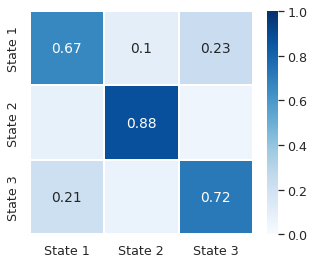

In [14]:
hu.plot_transition_matrix(hmm.A, figsize=(5, 5), filename=module_path + "/plots/hmm_A.pdf")

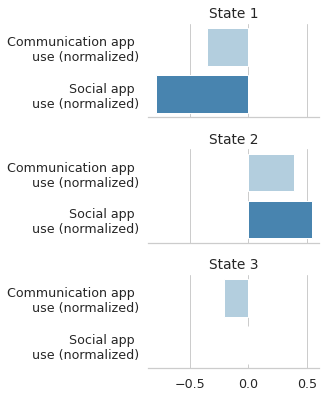

In [13]:
hu.plot_state_means(hmm, ["Communication app \n use (normalized)", "Social app \n use (normalized)"], filename=module_path + "/plots/hmm_mu.pdf")


#### States over time for each patient

In [12]:
from src.utils import save_figures_to_pdf

figs = []
for pid in df_train.user.unique():
    df_patient = df_train[df_train.user == pid].copy()
    _, state_seq = hmm.decode([df_patient[data_columns].values])
    figs.append(hu.plot_states_over_time(df_patient, data_columns, state_seq[-1], figsize=(7, 5)))

save_figures_to_pdf(figs, PATH_TO_RESULTS + "3_sate_hmm_decoding.pdf")

### 5-state HMM

#### Model parameters

In [13]:
# --- load the trained model
hmm = hu.load_model(folder_path + "5_state_hmm.p")

# --- print model parameters
hu.pretty_print_hmm(hmm, hmm_type="Gaussian", emissions=data_columns)

Priors
+------------+------------+------------+------------+------------+
|  State_0   |  State_1   |  State_2   |  State_3   |  State_4   |
+------------+------------+------------+------------+------------+
| P(0)=0.165 | P(1)=0.269 | P(2)=0.088 | P(3)=0.229 | P(4)=0.249 |
+------------+------------+------------+------------+------------+
Transitions
+---------+--------------+--------------+--------------+--------------+--------------+
|    _    |   State_0    |   State_1    |   State_2    |   State_3    |   State_4    |
+---------+--------------+--------------+--------------+--------------+--------------+
| State_0 | P(0|0)=0.338 | P(1|0)=0.167 | P(2|0)=0.215 | P(3|0)=0.119 | P(4|0)=0.162 |
| State_1 | P(0|1)=0.132 | P(1|1)=0.599 | P(2|1)=0.078 | P(3|1)=0.116 | P(4|1)=0.075 |
| State_2 | P(0|2)=0.194 | P(1|2)=0.110 | P(2|2)=0.300 | P(3|2)=0.107 | P(4|2)=0.289 |
| State_3 | P(0|3)=0.060 | P(1|3)=0.088 | P(2|3)=0.059 | P(3|3)=0.738 | P(4|3)=0.056 |
| State_4 | P(0|4)=0.080 | P(1|4)=0.0

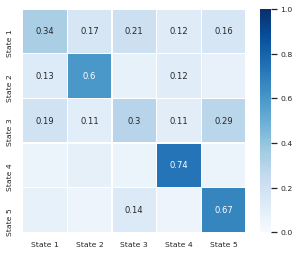

In [14]:
hu.plot_transition_matrix(hmm.A, figsize=(5, 5))

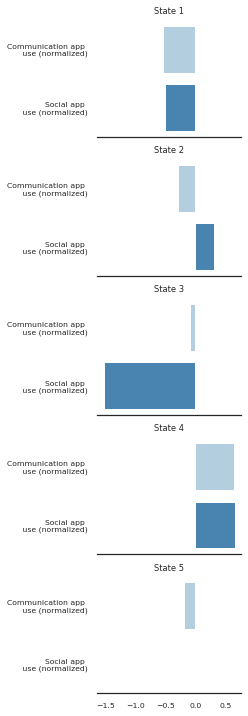

In [15]:
hu.plot_state_means(hmm, ["Communication app \n use (normalized)", "Social app \n use (normalized)"])

#### States over time for each patient

In [17]:
from src.utils import save_figures_to_pdf

figs = []
for pid in df_train.user.unique():
    df_patient = df_train[df_train.user == pid].copy()
    _, state_seq = hmm.decode([df_patient[data_columns].values])
    figs.append(hu.plot_states_over_time(df_patient, data_columns, state_seq[-1], figsize=(10, 5)))

save_figures_to_pdf(figs, PATH_TO_RESULTS + "5_sate_hmm_decoding.pdf")

